# Inspired by ''A Neural Algorithm of Artistic Style" by Leon A. Gatys, Alexander S. Ecker, and Matthias Bethge (https://arxiv.org/abs/1508.06576)

The technique uses content image and style image to generate the image with similar content to the content image but in the style of the style image. Neural Style Transfer uses a previously trained convolutional network, and builds on top of that. Here, VGG19 is going to be used (https://arxiv.org/abs/1409.1556)

### Imports and Model Load

In [83]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [84]:
# Load the model without top layer
vgg19 = tf.keras.applications.VGG19(include_top = False,
                                    weights = 'imagenet',
                                    input_shape = (400, 400, 3))

# Set trainable parameters to False
vgg19.trainable = False

In [85]:
# Print all model's layers
for layer in vgg19.layers:
  print(layer.name)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


For neural style transfer to work, we need to define two distance functions:
* between content image (C) and generated image (G): $d_{content}(C, G)$,
* between style image (S) and generated image (G): $d_{style}(S, G)$
* total distance: $d_{total} = \alpha d_{content}(C, G) + \beta d_{style}(S, G)$

Let's define:
* $d_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum (a^{(C)} - a^{(G)})^2$, where $a^{(C)}$ and $a^{(G)}$ are activations for content and generated image extracted from some hidden (not too shallow not too deep) layer of pre-trained network.
* $d_{style}(S, G) =  \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2$, where $G_{gram}^{(S)}$ is Gram matrix of the style image and $G_{gram}^{(G)}$ is Gram matrix of the generated image. The Gramm matrix is calculated as $\vec A^T  \cdot \vec A$, where $\vec A$ is the activation vector of dimension $(n_H \cdot n_W,  n_C)$ for some hidden layer. The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels).


In [86]:
def content_cost(a_C, a_G):
  '''
  Calculates the distance between content image activations and generated image
  activations according to the above formula

  Args:
    a_C - tensor of dimension (1, n_H, n_W, n_C): activations for content image
    a_G - tensor of dimension (1, n_H, n_W, n_C):  activations for generated image

  Returns:
    d_content (float): distance between content photo and generated photo
  '''
  # Get height, width and number of channels from input
  n_H = a_C.shape[1]
  n_W = a_C.shape[2]
  n_C = a_C.shape[3]

  # Inputs to this function will have batch dimension (axis 0). Need to remove it
  a_C_squeezed = tf.squeeze(a_C)
  a_G_squeezed = tf.squeeze(a_G)

  # Reshape inputs so that they are in matrix form
  a_C_reshaped = tf.reshape(a_C_squeezed, shape = (n_H * n_W, n_C))
  a_G_reshaped = tf.reshape(a_G_squeezed, shape = (n_H * n_W, n_C))

  # Calculate distance
  d_content = 1/(4 * n_H * n_W * n_C) * tf.reduce_sum(tf.square(tf.subtract(a_C_reshaped, a_G_reshaped)))

  return d_content

In [87]:
def style_cost_single_layer(a_S, a_G):
  '''
  Calculates the distance between style image activations and generated image
  activations according to the above formula (for single layer activations)

  Args:
    a_S - tensor of dimension (1, n_H, n_W, n_C): activations for style image
    a_G - tensor of dimension (1, n_H, n_W, n_C):  activations for generated image

  Returns:
    d_style (float): distance between style photo and generated photo
  '''
  # Get height, width and number of channels from input
  n_H = a_S.shape[1]
  n_W = a_S.shape[2]
  n_C = a_S.shape[3]

  # Inputs to this function will have batch dimension (axis 0). Need to remove it
  a_S_squeezed = tf.squeeze(a_S)
  a_G_squeezed = tf.squeeze(a_G)

  # Reshape inputs so that they are in matrix form
  a_S_reshaped = tf.reshape(a_S_squeezed, shape = (n_H * n_W, n_C))
  a_G_reshaped = tf.reshape(a_G_squeezed, shape = (n_H * n_W, n_C))

  # Define Gramm matrices for style and generated photos
  Gramm_S = tf.matmul(tf.transpose(a_S_reshaped), a_S_reshaped)
  Gramm_G = tf.matmul(tf.transpose(a_G_reshaped), a_G_reshaped)

  # Calculate distance
  d_style = 1/(4 * (n_H * n_W * n_C)**2) * tf.reduce_sum(tf.square(tf.subtract(Gramm_S, Gramm_G)))

  return d_style

In practice, it is best to combine style cost from a couple of layers (not just one). Each layer $l$ is assigned some weight $\lambda_l$ and the total style cost is weighted average: $\sum_i \lambda_i d_{style}^{i}$, where $\sum_i \lambda_i = 1$

In [88]:
def style_cost(a_S, a_G, style_layers):
  '''
  Calculates style cost for multiple layers with weights

  Args:
    a_S - list of tensors of dimension (1, n_H_i, n_W_i, n_C_i): activations for style image for i-th layer
    a_G - list of tensors of dimension (1, n_H_i, n_W_i, n_C_i):  activations for generated image for i-th layer
    style_layers - list with layer names and their corresponding weights

  Returns:
    d_style_total (float): distance between style photo and generated photo
  '''
  # Initialize d_style
  d_style_total = 0

  for i, weight in zip(range(len(a_S)), style_layers):
    # Compute d_style for current layer
    d_style = style_cost_single_layer(a_S[i], a_G[i])
    # Update d_style_total
    d_style_total += d_style * weight[1]

  return d_style_total


In [89]:
def total_cost(d_content, d_style, alpha = 1, beta = 4):
  '''
  Calculates total distance, which combines content distance and style distance

  Args:
    d_content (float): distance between content photo and generated photo
    d_style (float): distance between style photo and generated photo
    alpha (float): weight of d_content
    beta (float): weight of d_style
  '''
  # Calculate total distance
  d_total = d_content * alpha + d_style * beta
  return d_total

### Define content and style layers

In [90]:
# Define content layer (formatted as STYLE_LAYERS)
CONTENT_LAYER = [('block5_conv4', 1)]

# Style layers in (layer_name, weight) format (later layers get smaller weights -> generated image will STRONGLY follow the style of style image)
# (1/16 + 1/16 + 1/8 + 1/4 + 1/2 = 1)
STYLE_LAYERS = [
                ('block1_conv1', 0.5),
                ('block2_conv1', 0.25),
                ('block3_conv1', 0.125),
                ('block4_conv1', 0.0625),
                ('block5_conv1', 0.0625)]

### Load content image and style image(s)

In [91]:
%cd /content/drive/MyDrive/TensorFlow_projects/style_transfer

/content/drive/MyDrive/TensorFlow_projects/style_transfer


In [92]:
from PIL import Image

content_image = Image.open("foto.jpg")

In [93]:
style_image = Image.open("pablo-picasso-linocut-portrait-of-a-woman-with-a-hat-1962-bloch-1072-for-sale.jpg")

### Preprocessing images

In [94]:
# Resizing images to (400 x 400), normalizing and casting to numpy arrays
content_image_preprocessed = np.array(content_image.resize((400, 400)))/255.
style_image_preprocessed = np.array(style_image.resize((400, 400)))/255.

content_image_preprocessed.shape

(400, 400, 3)

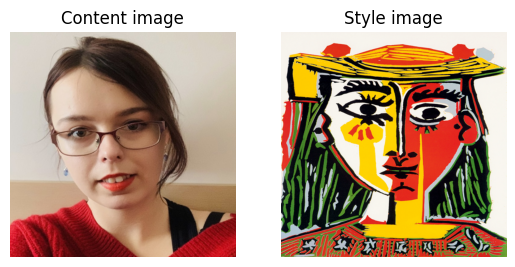

In [95]:
# Plotting images
fig, ax = plt.subplots(nrows = 1, ncols = 2)

ax[0].imshow(content_image_preprocessed)
ax[1].imshow(style_image_preprocessed)

ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Content image')
ax[1].set_title('Style image')

plt.show()

In [96]:
# Expressing images as constant tensors (their value do not change over training)
content_image_preprocessed = tf.constant(content_image_preprocessed, dtype = tf.float32)
style_image_preprocessed = tf.constant(style_image_preprocessed, dtype = tf.float32)

# Creating artificial 1st dimension (batch dimension)
content_image_preprocessed = tf.expand_dims(content_image_preprocessed, axis = 0)
style_image_preprocessed = tf.expand_dims(style_image_preprocessed, axis = 0)

content_image_preprocessed.shape

TensorShape([1, 400, 400, 3])

### Initialize the image to be generated

It is best that initial generated image is a mixture of (mostly) noise and (slightly) content image. This improves training

In [97]:
# Generated image has to be Variable tensor
# First, generated image is set equal to content_image
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image_preprocessed, tf.float32))
# Define noise
noise = tf.random.uniform(shape = content_image_preprocessed.shape, minval = -0.25, maxval = 0.25)
# Define generated image as the sum of generated image and noise
generated_image = tf.add(generated_image, noise)
# After addition clip each pixel value to be in the interval (0, 1)
generated_image = tf.clip_by_value(generated_image, clip_value_min = 0.0, clip_value_max = 1.0)
# Casting generated image to Variable tensor for future updates
generated_image = tf.Variable(generated_image)

### Get a list of outputs for hidden layers

In [98]:
def get_outputs(model, layer_names):
  '''
  Creates a vgg model that returns a list of intermediate output values
  '''
  outputs = [model.get_layer(layer[0]).output for layer in layer_names]
  # Define model whose inputs are the same as VGG19 inputs, and outputs as defined above
  model = tf.keras.Model(inputs = [model.input], outputs = outputs)

  return model

### Build the model

In [99]:
vgg_model_outputs = get_outputs(model = vgg19, layer_names = STYLE_LAYERS + CONTENT_LAYER)

In [100]:
# Save outputs for content image and style image
content_targets = vgg_model_outputs(content_image_preprocessed)
style_targets = vgg_model_outputs(style_image_preprocessed)

In [101]:
# Extract appropriate a_C (tensor) and a_S (list of tensors) from outputs of previous cell
a_C = content_targets[-1] # last element of content_targets is encoding of content image
a_S = style_targets[:-1] # all but the last element of style targets encode style photo

### Define utilities to display images generated by style transfer model

In [102]:
def clip(image):
    """
    clip each pixel value to be in the interval (0, 1)

    Arguments:
      image (Tensor): image to be clipped

    Returns:
      Clipped image
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts given tensor into a PIL image

    Arguments:
      tensor (Tensor): Generated tensor representation of image

    Returns:
      image: A PIL image obtained from tensor
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)


### Build training loop using `tf.GradientTape`

In [103]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
  '''
  Args:
    generated_image (ndarray): image of similar content as content image and similar style to style image
                                It's pixels are updated so that distance function is minimized
  '''
  with tf.GradientTape() as tape:

    # Compute a_G as the vgg_model_outputs for the current generated image
    generated_outputs = vgg_model_outputs(generated_image)

    # Retrieve from generated_outputs appropriate a_G vectors
    a_G_content = generated_outputs[-1] # last element is will be compared with a_C
    a_G_style = generated_outputs[:-1] # all buts last element will be compared with a_S

    # Compute the content cost
    d_content = content_cost(a_C, a_G_content)

    # Compute the style cost
    d_style = style_cost(a_S, a_G_style, style_layers = STYLE_LAYERS)

    # Compute the total cost
    d_total = total_cost(d_content, d_style, alpha = 10, beta = 40)

  # Calculate gradients
  grad = tape.gradient(d_total, generated_image)

  # Do gradient descent step
  optimizer.apply_gradients([(grad, generated_image)])
  generated_image.assign(clip(generated_image))
  # Returns total cost
  return d_total

In [104]:
type(generated_image)

tensorflow.python.ops.resource_variable_ops.ResourceVariable

In [105]:
type(tf.Variable(1.0))

tensorflow.python.ops.resource_variable_ops.ResourceVariable

### Train model

In [106]:
# Trains and shows the generated image at some epochs
epochs = 20000
for i in range(epochs):
  train_step(generated_image)
  if i % 250 == 0:
    plt.clf()
    print(f"Epoch {i} ")
    image = tensor_to_image(generated_image)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [116]:
gen = generated_image.numpy().squeeze()

In [117]:
import matplotlib.image

matplotlib.image.imsave('generated.png', gen)

### Show all images

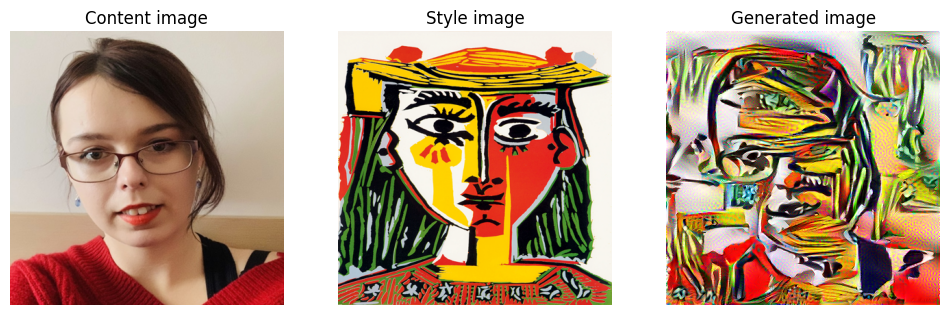

In [121]:
fig, ax = plt.subplots(nrows = 1, ncols = 3)
fig.set_size_inches((12,12))

content = content_image_preprocessed.numpy().squeeze()
style = style_image_preprocessed.numpy().squeeze()

ax[0].imshow(content)
ax[1].imshow(style)
ax[2].imshow(gen)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Content image')
ax[1].set_title('Style image')
ax[2].set_title('Generated image')

plt.show()